In [1]:
import pandas as pd
from Bio import SeqUtils
from Bio import AlignIO
from rpy2.robjects.packages import importr
import numpy as np

ggplot2 = importr('ggplot2')
ggtree = importr('ggtree')
ape = importr('ape')
patchwork = importr('patchwork')
reshape2 = importr('reshape2')
gridExtra = importr('gridExtra')
ggtext = importr('ggtext')
hash = importr('hash')
ggrepel = importr('ggrepel')
ggmsa = importr('ggmsa')
msa = importr('msa')

In [851]:
# for OLD weighted phact files, with columns: "Pos/AA" and "wt"

def phact_score(uniprot, position, mut):
    """
    :param uniprot: The uniprot name of the protein
    :param position: The position of the mutation in the protein
    :param mut: The mutation that is being checked
    :return: The PHACT score of the base given by mut in the location provided
    """
    mut = mut.upper()
    df_phact = pd.read_csv(f"{uniprot}_weight_Max05.csv")
    df_phact = df_phact.loc[df_phact['Pos/AA'] == position]
    df_phact = df_phact.reset_index(drop=True)
    return round(float(df_phact[mut]), 4)

def phact_from_S_I_S(mystr):
    """
    :param mystr: The string that contains the information of the mutation in the format of "wt_location_mut"
    :return: The PHACT score of the base given by mut in the location provided
    """

    vals = mystr.split("_")
    position = int(vals[1])
    mut = vals[2]
    df_phact2 = pd.read_csv(f"{uniprot_name}_weight_Max05.csv")
    df_phact2 = df_phact2.loc[df_phact2['Pos/AA'] == position]
    df_phact2 = df_phact2.reset_index(drop=True)
    return round(float(df_phact2[mut]), 4)

# for NEW weighted phact files, with columns: "unique_id" "position" "ref_aa" "alt_aa" "phact_score

def phact_score(uniprot, position, mut):
    """
    :param uniprot: The uniprot name of the protein
    :param position: The position of the mutation in the protein
    :param mut: The mutation that is being checked
    :return: The PHACT score of the base given by mut in the location provided
    """
    mut = mut.upper()
    df_phact3 = pd.read_csv(f"{uniprot_name}_weight_Max05.csv")
    df_phact3 = df_phact3.loc[df_phact3['Positions'] == position]
    df_phact3 = df_phact3.loc[df_phact3['Alt_AA'] == mut]
    df_phact3 = df_phact3.reset_index(drop=True)
    value = df_phact3["PHACT Score"]
    return round(float(value), 4)

def phact_from_S_I_S(mystr):
    """
    :param mystr: The string that contains the information of the mutation in the format of "wt_location_mut"
    :return: The PHACT score of the base given by mut in the location provided
    """

    vals = mystr.split("_")
    position = int(vals[1])
    mut = vals[2]
    df_phact4 = pd.read_csv(f"{uniprot_name}_weight_Max05.csv")
    df_phact4 = df_phact4.loc[df_phact4['Positions'] == position]
    df_phact4 = df_phact4.loc[df_phact4['Alt_AA'] == mut]
    df_phact4 = df_phact4.reset_index(drop=True)
    value = df_phact4["PHACT Score"]
    return round(float(value), 4)


def mut_in_alg(msa_handel, mut_effect, dataframe):
    """

    :param msa_handel: Path of the file that contains the MSA data
    :param mut_effect: Which effect you want to look from the database
    :param dataframe: The path to the dataframe that contains the protein molecular phenotypes associated to human missense variants
    :return: df_mut= The dataframe that contains columns with keys "wt_location_mut_effect" and values as protein names from the allignment file that contains those mutations
             mut_effect= Effect parameter that was entered to the function

    """

    #df = pd.read_json(dataframe)
    df = dataframe

    alignments = AlignIO.read(msa_handel, "fasta")
    mut_dict = {}
    all_aa_list = []

    for alg in alignments:
        for asd, pos in enumerate(df["position"]):
            asd = int(asd)
            pos = int(pos)
            all_aa_list.append(alg.seq[pos-1])
            if alg.seq[pos-1] in df['mutation'][asd].split(","):
                if alg.seq[pos-1] in df['mutation'][asd].split(","):
                    effect = "non"
                    if pd.isnull(df[mut_effect][asd]):
                        effect = "NaN"
                    elif df[mut_effect][asd] == 1:
                        effect = "pos"
                    elif df[mut_effect][asd] == -1:
                        effect = "neg"

                phact_value = phact_score(uniprot_name, df['position'][asd], alg.seq[pos-1])
                key = f"{df['wildtype'][asd]}_{df['position'][asd]}_{alg.seq[pos-1]}_{effect}_{phact_value}"  #key = wt_location_mut_effect-to-func
                if key not in mut_dict:
                    mut_dict[key] = [alg.name]
                else:
                    mut_dict[key].append(alg.name)


    mut_names = []
    mut_pros = []

    for mut, names in mut_dict.items():
        mut_names.append(mut)
        mut_pros.append(names)

    df_mut = pd.DataFrame.from_dict(mut_dict, orient='index').transpose()


    return df_mut, mut_effect, mut_dict, all_aa_list

In [852]:
# This is required to run Python and R code in the same notebook.
%reload_ext rpy2.ipython

In this cell we create the variables that will be used in the rest of the notebook.

Firstly, we take the name of the protein that we will check for mutations. Also we will need the name of an effect thats in the HPMP database to check how did that mutation affect the protein.

Then, we take the HPMP database and create a df that contains "uniprot_id, wildtype, position, mutation, phenotypic annotations, and what effect did these mutations have on the protein" for the given protein name.

Also we create variables tree_name and msa_name which takes raxml tree files and msa files, respectively, for the given protein name. Note that these files are in the same folder as this notebook.

In [9]:
uniprot_name = "P15104"
my_effect = "subcell_localization_change"

# tree_name= f"{uniprot_name}.raxml.ancestralTree"
# msa_name= f"{uniprot_name}_nogap_msa.fasta"

tree_name= f"{uniprot_name}.treefile"
msa_name = f"{uniprot_name}_MaskedMSA.fasta"

pro_name = tree_name.split(".")[0]
df = pd.read_csv("HPMP_database.tsv", sep='\t')
df_og = pd.read_csv("HPMP_database.tsv", sep='\t')
df = df.loc[df['uniprot_id'] == pro_name]
df = df.reset_index(drop=True)
df = df.astype({'position':'int'})
df

,uniprot_id,wildtype,position,mutation,pdb_id,pdb_position,phenotypic_annotation,interaction,binding,function,...,glycosylation,sumoylation,acetylation,other_ptm,methylation,ribosylation,subcell_localization_change,mimetic_ptm,folding,expression
0,P15104,C,209,A,2qc8:A,209.0,Reduced ability to mediate autopalmitoylation.,NaN,NaN,-1.0,...,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,P15104,R,324,"A,C",2qc8:A,324.0,Decreases ribolosomal 40S subunit synthesis. L...,NaN,NaN,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In this cell we take merge2.txt file that contains the pathogenic mutations that are seen in both the HPMP database and the Clinvar database. We then create a dictionary that contains the uniprot_id as the key and the value is a list of the mutations.

In [854]:
three_to_one = {"Ala": "A", "Arg": "R", "Asn": "N", "Asp": "D",
                "Cys": "C", "Glu": "E", "Gln": "Q", "Gly": "G",
                "His": "H", "Ile": "I", "Leu": "L", "Lys": "K",
                "Met": "M", "Phe": "F", "Pro": "P", "Ser": "S",
                "Thr": "T", "Trp": "W", "Tyr": "Y", "Val": "V",
                "Sec": "U", "-": "-"}

# create a dictionary with key = uniprot name and value = mutation list location from merge2.txt
with open("merge2.txt") as file:
    lines = file.readlines()
lines = [i.strip().split() for i in lines]

line_dict = {}
for i in lines:
    value = i[1][2:]
    wt = three_to_one[value[0:3]]
    mt = three_to_one[value[-3:]]
    location = value[3:-3]
    value = f"{wt}_{location}_{mt}"
    if i[0] not in line_dict:
        line_dict[i[0]] = [value]
    else:
        line_dict[i[0]].append(value)

line_dict[pro_name]

['E_95_G']

Here we create another dataframe that contains the phact score data to be used in the phact score functions and to be added to the figures created.

In [855]:
df_phact = pd.read_csv(f"{uniprot_name}_weight_Max05.csv")
# df_phact = df_phact.loc[df_phact['Positions'] == 108]
# df_phact = df_phact.loc[df_phact['Alt_AA'] == "W"]

df_phact

,UNIPROTKB,Positions,Ref_AA,Alt_AA,PHACT Score
0,Q14623,1,M,G,0.000000
1,Q14623,1,M,A,0.000000
2,Q14623,1,M,L,0.000000
3,Q14623,1,M,M,0.000736
4,Q14623,1,M,F,0.000000
...,...,...,...,...,...
8215,Q14623,411,S,H,0.000244
8216,Q14623,411,S,R,0.000555
8217,Q14623,411,S,N,0.000471
8218,Q14623,411,S,D,0.000368


Finally in this cell we run the function mut_in_alg to create df_mut that contains "wt_pos_mut_effect_phact" as columns and the species that contains that mutation on the MSA as rows. If the df_mut is empty we create a none column to later add CLINVAR as an indication that the MSA had 0 mutation from the HPMP database. Also we delete any columns that are not found in line_dict[pro_name] to ensure that only pathogenic mutations are left on the dataframe. And if there are no mutations seen in MSA for a pathogenic mutation, we add a row "CLINVAR" to indicate this.

In [857]:
df_mut, effect, mut_dict, all_aas = mut_in_alg(msa_name, my_effect, df)

# if df_mut is empty, create a pandas dataframe pd.DataFrame(index=[0,1,2,3,4]) with column "None"
if df_mut.empty:
    np_array1 = np.arange(0, 10, 1)
    df_mut = pd.DataFrame(index=np_array1)
    df_mut["Placeholder"] = None

# delete the column in df_mut if it doesn't contain line_dict[pro_name] mutations
for i in df_mut.columns:
        x = "_".join(i.split("_")[0:3])
        if x not in line_dict[pro_name]:
            df_mut = df_mut.drop(i, axis=1)

# create a new column in df_mut if there is no mutation seen on msa
for j in line_dict[pro_name]:
    if not any(j in s for s in list(df_mut.columns)):
        effect_df = df_og.loc[df_og['uniprot_id'] == uniprot_name]
        effect_df = effect_df.loc[effect_df['mutation'].str.contains(j.split("_")[2])]
        effect_df = effect_df.loc[effect_df['position'] == float(j.split("_")[1])]
        if effect_df[my_effect].isnull().values.any():
            effect2 = "NaN"
        elif effect_df[my_effect].values[0] == 1:
            effect2 = "pos"
        elif effect_df[my_effect].values[0] == -1:
            effect2 = "neg"
        else:
            effect2 = "non"
        phact_value = phact_from_S_I_S(j)
        j = f"{j}_{effect2}_{phact_value}"
        df_mut[j] = None
        df_mut[j][0] = "CLINVAR"

df_mut

,E_95_G_pos_0.0
0,CLINVAR
1,None
2,None
3,None
4,None
5,None
6,None
7,None
8,None
9,None


This part takes all of the amino acids that were seen in the mutation position and checks their features.

In [ ]:
aa_list = []
for key in list(df_mut.columns):
    a =key.split("_")
    aa_list.append(f"{a[0]} {a[2]}")
aa_set = set(aa_list)

aa_feats = pd.read_csv("AA features.csv", sep = ';', index_col=0)

comperison_list = []
for pair in aa_set:
    i, j = pair.split()
    aa1, aa2 = SeqUtils.IUPACData.protein_letters_1to3[i], SeqUtils.IUPACData.protein_letters_1to3[j]
    name = f"df_{i}{j}"
    name = aa_feats.loc[[aa1, aa2]]
    comperison_list.append(name)

df_merged = pd.concat(comperison_list, axis=0)
df_merged = df_merged[~df_merged.index.duplicated(keep='first')]
df_merged.index = df_merged.index.map(lambda x: f"{x}({SeqUtils.IUPACData.protein_letters_3to1[x]})")
df_merged.to_csv(f"{pro_name} Patho/{pro_name}_{effect}_mutated_amino_acids.csv")
df_merged


In this cell we send the data to R to create the figures and to run the R functions.

In [858]:
"""
R part needs:
    tree_name = Path to the newick file that contains tree data
    df_mut = Return from mut_in_alg(), contains protein name data
    effect = Which parameter that mutations effect
    df_og = Complete dataframe from the HPMP database
    pro_name = Uniprot name of the protein
    msa_name = Path to the MSA file
"""

%R -i tree_name -i df_mut -i effect -i df_og -i pro_name -i msa_name

## R Section

In this first cell we create a grid of phylogenetic tree figures from the data we obtained from python. For each protein, this grid contains all the pathogenic mutations that are stored on the df_mut. The title contains the uniprot id, the effect of the mutation and whether or not the mutation is found in the MSA. In each grid the tree is labeled with the name of the species that contains that mutation. The title of these grids contains the phact score of the mutation. Also the clade that contains the human protein in each grid is highlighted in blue. This figures are added to a folder named after the protein.

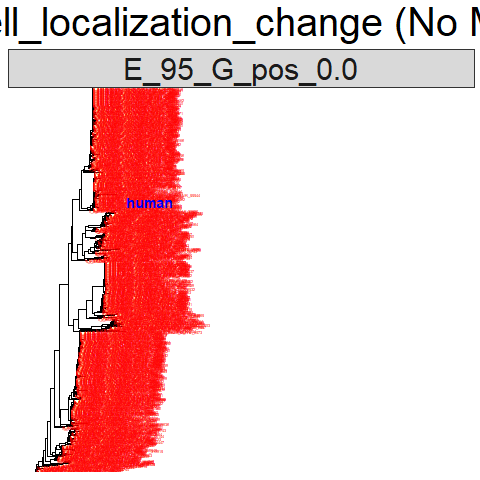

In [859]:
%%R

tail(names(sort(table(df_og$uniprot_id))), 25)

tree <- read.tree(tree_name)
df <- df_mut


key <- paste("^sp_", pro_name, ".+", "HUMAN_9606$", sep="")

hum_loc <- grep(key, tree$tip.label)
mut_loc <- gsub("\\D", "", names(df))
    #hum_loc <- grep("sp_Q9Y6X9_MYO16_HUMAN_9606", tree$tip.label)
hum_loc
tree$tip.label[12]

pro_list <- lapply(df, na.omit)
pro_list <- lapply(pro_list, c)


# creates tree objects for each entry in pro_list and adds them to a list
tree_list <- list()
for (i in 1:length(pro_list)) {
  vari <- paste("tree", i, sep = "")
  vari <- tree
  tree_list[[i]] <- vari
}


# creates location list for the proteins
lc_list <- list()
for (i in 1:length(pro_list)) {
  vari_lc <- paste("lc", i, sep = "")
  vari_lc <- match(pro_list[[i]], tree$tip.label)
  if (NA %in% vari_lc) {
  vari_lc <- 0
  }
  lc_list[[i]] <- vari_lc
}


# deletes the nodes that are not in the protein list
for (i in 1:length(lc_list)) {
  tree_list[[i]]$tip.label[-lc_list[[i]]] <- ""
}



trees <- tree_list
class(trees) <- "multiPhylo"

plot_labeller <- function(variable) {
    variable = names(df)
}

title <- paste(pro_name, " ", effect)

tip_size <- 1.5
alpha <- 1
effect2 <- effect

if ('CLINVAR' %in% df[1,]) {
  title <- paste(pro_name, " ", effect, " (No Mutation Seen)", sep = "")
  effect2 <- paste(effect, " (No Mutation Seen)", sep = "")
}


p <- ggtree(trees) +
    geom_tiplab(size = tip_size, color = "red", alpha = 1) +
    ggtitle(title) +
    facet_wrap(~.id, labeller = as_labeller(plot_labeller), scales = "free") +
    theme(plot.title = element_text(hjust = 0.5, size = 40), strip.text = element_text(size=30)) +
    geom_cladelabel(node=hum_loc, label="human", color="blue", offset.text=0.5, fill="white", fontsize=5, fontface="bold") +
    xlim(-.1, 7)

dirname <- paste(pro_name, " Patho", sep = "")
dir.create(dirname)


ggsave(plot = p, filename = paste(dirname, "/", pro_name, "_", effect2, ".png", sep = ""), width = 30, height = 30, dpi = 300)
p



And in this cell we create figures for each mutation that is also created in the previous cell but in this figures we add the alignment data in the position of the mutation. The mutation position is the middle amino acid in the figures. The clades that contain the mutation are labeled with "*".

In [861]:
%%R

tree <- read.tree(tree_name)

for (i in 1:length(mut_loc)) {
    split <- strsplit(names(df)[i], "_")

  p <- msaplot(p=ggtree(tree), fasta= msa_name, window = c(as.numeric(split[[1]][2])-1, as.numeric(split[[1]][2])+1)) +
       ggtitle(names(df)[i]) +
       theme(plot.title = element_text(hjust = 0.72, size = 40), strip.text = element_text(size=30), legend.key.size = unit(2, 'cm'), legend.text = element_text(size=30)) +
       geom_cladelabel(node=hum_loc, label="human", color="blue", offset.text=0.5, fill="white", fontsize=5, fontface="bold")

  for (j in lc_list[i]) {
  if (0 %in% j) {
  break
  }
    p <- p + geom_cladelab(node=j, label="*", fontsize = 10, color='red', offset=0.5)
  }


  file_loc = paste(dirname, "/ (Patho)", pro_name, "_", effect, "_", names(df)[i] ,"_msa.png", sep = "")
  ggsave(plot = p, filename = file_loc, width = 30, height = 30, dpi = 300)
}